# t-SNE plots 
```shell
conda install anaconda::scikit-learn
```

In [36]:
from sklearn.manifold import TSNE
from lib.datasets import FilterAudioMNIST
from lib.wavUtils import pad_trunc
import os

base_path = '/home/andyshao'
mnist_training = FilterAudioMNIST(
    root_path=os.path.join(base_path, 'data', 'AudioMNIST', 'data'),
    filter_fn=lambda x: x['accent']== 'German',
    data_tsf=pad_trunc(max_ms=1000, sample_rate=48000),
    include_rate=False
)
mnist_test = FilterAudioMNIST(
    root_path=os.path.join(base_path, 'data', 'AudioMNIST', 'data'),
    filter_fn=lambda x: x['accent']!= 'German',
    data_tsf=pad_trunc(max_ms=1000, sample_rate=48000),
    include_rate=False
)

mnist_training[0][0].shape

torch.Size([1, 48000])

In [37]:
from torch.utils.data import Dataset

class FilterDataset(Dataset):
    def __init__(self, dataset:Dataset, allow_labels:list[int]):
        self.dataset = dataset
        self.allow_labels = allow_labels
        self.indexes = self.__acceptable_index__()

    def __acceptable_index__(self) -> list[int]:
        ret = []
        for index, (_, label) in enumerate(self.dataset):
            if label in self.allow_labels:
                ret.append(index)
        return ret
    
    def __len__(self):
        return len(self.indexes)

    def __getitem__(self, index):
        return self.dataset[self.indexes[index]]
    
mnist_training = FilterDataset(dataset=mnist_training, allow_labels=[0])
mnist_test = FilterDataset(dataset=mnist_test, allow_labels=[0])
len(mnist_training)


2000

In [38]:
import torch 

def cal_tsne_features(dataset: Dataset) -> torch.Tensor:   
    features = None
    for index, (feature, _) in enumerate(mnist_training):
        if index == 0:
            features = feature
        else:
            features = torch.cat([features, feature], dim=0)
    features = features.detach().cpu().numpy()
    tsne = TSNE(n_components=2, random_state=42)
    tsne_features = tsne.fit_transform(features)
    return tsne_features

tsne_train = cal_tsne_features(dataset=mnist_training)
tsne_test = cal_tsne_features(dataset=mnist_test)

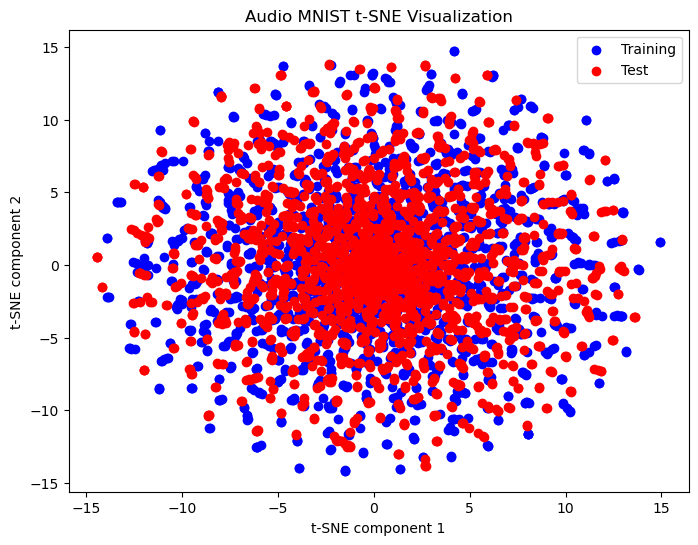

In [39]:
import matplotlib.pyplot as plt

def tSNE_show(tsne_train, tsne_test, title:str) -> None:
    plt.figure(figsize=(8, 6))
    plt.scatter(tsne_train[:, 0], tsne_train[:, 1], c='blue', label='Training')
    plt.scatter(tsne_test[:, 0], tsne_test[:, 1], c='red', label='Test')
    plt.title(title)
    plt.xlabel('t-SNE component 1')
    plt.ylabel('t-SNE component 2')
    plt.legend()
    plt.show()

tSNE_show(tsne_train, tsne_test, title='Audio MNIST t-SNE Visualization')

In [40]:
from lib.scDataset import SpeechCommandsDataset

sc_training = SpeechCommandsDataset(
    root_path=os.path.join(base_path, 'data', 'speech_commands'),
    mode='train',
    data_tfs=pad_trunc(max_ms=1000, sample_rate=16000),
    include_rate=False,
    data_type='all'
)

sc_test = SpeechCommandsDataset(
    root_path=os.path.join(base_path, 'data', 'speech_commands'),
    mode='test',
    data_tfs=pad_trunc(max_ms=1000, sample_rate=16000),
    include_rate=False,
    data_type='all'
)

sc_training = FilterDataset(dataset=sc_training, allow_labels=[0.])
sc_test = FilterDataset(dataset=sc_test, allow_labels=[0.])
len(sc_training)

1866

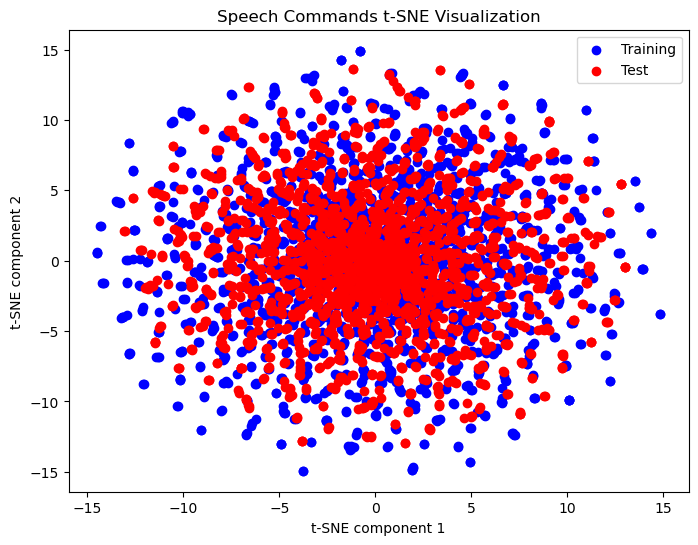

In [41]:
tsne_train = cal_tsne_features(dataset=sc_training)
tsne_test = cal_tsne_features(dataset=sc_test)

tSNE_show(tsne_train, tsne_test, title='Speech Commands t-SNE Visualization')